<html>
Candidate Number : BSYP1 <br>
Github link : https://github.com/bsyp1/assignment<br>
Word count : 2497 (not including code, raw code output, tables, figures and headings thereof)
<html>

In [1]:
import pandas as pd
from pandasql import PandaSQL
pdsql = PandaSQL()
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assignment A

<html>
<font color='green' size=2>
<bold>Overview</bold> <br><br>
UK general practice prescribing data for April 2018 (at a presentation level, i.e. total number of items, total net and actual cost and total quantity) were downloaded from https://digital.nhs.uk/data-and-information/. In addition,linked practice detail, prescription detail and patient numbers (per practice) data were downloaded from the same website. From this data information about practices, their prescribing patterns, number and cost of prescriptions are described for London and Cambridge. In addition number and total cost across all practices nationally are described for cardiovascular and antidepressant prescriptions. Total and relative spending per patient nationally are also described.
</font>
</html>

## 0. Data checking and cleaning

In [2]:
#Read in raw data files for GP data

#presentation level practice prescriptions (rxs)
url = 'https://files.digital.nhs.uk/38/03EC1C/T201804PDPI%20BNFT.CSV'
practice_rxs = pd.read_csv(url)
practice_rxs.head()

#practice details
#by inspection of raw data, this file has no header info
cols = ['DATE','PRACTICE', 'PRACTICE_NAME', 'ADD1', 'ADD2','ADD3','ADD4', 'POSTCODE']
url = 'https://files.digital.nhs.uk/20/09E30B/T201804ADDR%20BNFT.CSV'
practice_details = pd.read_csv(url, names=cols)

#prescription details 
#by inspection of raw data, problematic column name was altered in raw data file (CHEM SUB -> CHEMSUB)
url = 'https://files.digital.nhs.uk/79/6D58A8/T201804CHEM%20SUBS.CSV'
rx_details = pd.read_csv(url)

#no. of patients per practice
url = 'https://files.digital.nhs.uk/71/B59D99/gp-reg-pat-prac-all.csv'
pats_per_practice = pd.read_csv(url)

In [3]:
#define a function to provide metadata on a given dataframe
def examine(df):
    print(df.shape)
    print(df.info(null_counts=True))
    print(df.describe(include=[np.number]).T)
    print(df.describe(include=[np.object, pd.Categorical]).T)
    return df.head()

In [4]:
#check practice_rxs
examine(practice_rxs)

(9748354, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9748354 entries, 0 to 9748353
Data columns (total 11 columns):
 SHA                                            9748354 non-null object
PCT                                             9748354 non-null object
PRACTICE                                        9748354 non-null object
BNF CODE                                        9748354 non-null object
BNF NAME                                        9748354 non-null object
ITEMS                                           9748354 non-null int64
NIC                                             9748354 non-null float64
ACT COST                                        9748354 non-null float64
QUANTITY                                        9748354 non-null int64
PERIOD                                          9748354 non-null int64
                                                9748354 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 818.1+ MB
None
             

,SHA,PCT,PRACTICE,BNF CODE,BNF NAME,ITEMS,NIC,ACT COST,QUANTITY,PERIOD,
0,Q44,RTV,Y04937,0401010Z0AAAAAA,Zopiclone_Tab 7.5mg,6,1.56,2.12,63,201804,
1,Q44,RTV,Y04937,0401020K0AAAHAH,Diazepam_Tab 2mg,4,0.87,1.15,73,201804,
2,Q44,RTV,Y04937,0401020K0AAAIAI,Diazepam_Tab 5mg,2,0.46,0.56,35,201804,
3,Q44,RTV,Y04937,0402010ABAAABAB,Quetiapine_Tab 25mg,1,2.60,2.52,14,201804,
4,Q44,RTV,Y04937,0402010ADAAAAAA,Aripiprazole_Tab 10mg,1,1.53,1.53,14,201804,


In [5]:
#tidy up prescription data

#get rid of spaces in column names
cols = practice_rxs.columns
print(cols)
cols = cols.map(lambda x: x.replace(' ', ''))
print(cols)
practice_rxs.columns = cols

#exclude blank 11th column 
practice_rxs=practice_rxs[['SHA', 'PCT', 'PRACTICE', 'BNFCODE', 'BNFNAME', 'ITEMS', 'NIC',
       'ACTCOST', 'QUANTITY', 'PERIOD']]

print(practice_rxs.shape)
practice_rxs.head()

Index([' SHA', 'PCT', 'PRACTICE', 'BNF CODE',
       'BNF NAME                                    ', 'ITEMS  ',
       'NIC        ', 'ACT COST   ', 'QUANTITY', 'PERIOD',
       '                 '],
      dtype='object')
Index(['SHA', 'PCT', 'PRACTICE', 'BNFCODE', 'BNFNAME', 'ITEMS', 'NIC',
       'ACTCOST', 'QUANTITY', 'PERIOD', ''],
      dtype='object')
(9748354, 10)


,SHA,PCT,PRACTICE,BNFCODE,BNFNAME,ITEMS,NIC,ACTCOST,QUANTITY,PERIOD
0,Q44,RTV,Y04937,0401010Z0AAAAAA,Zopiclone_Tab 7.5mg,6,1.56,2.12,63,201804
1,Q44,RTV,Y04937,0401020K0AAAHAH,Diazepam_Tab 2mg,4,0.87,1.15,73,201804
2,Q44,RTV,Y04937,0401020K0AAAIAI,Diazepam_Tab 5mg,2,0.46,0.56,35,201804
3,Q44,RTV,Y04937,0402010ABAAABAB,Quetiapine_Tab 25mg,1,2.60,2.52,14,201804
4,Q44,RTV,Y04937,0402010ADAAAAAA,Aripiprazole_Tab 10mg,1,1.53,1.53,14,201804


In [6]:
#check practice details
examine(practice_details)

(9578, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 8 columns):
DATE             9578 non-null int64
PRACTICE         9578 non-null object
PRACTICE_NAME    9578 non-null object
ADD1             9578 non-null object
ADD2             9578 non-null object
ADD3             9578 non-null object
ADD4             9578 non-null object
POSTCODE         9578 non-null object
dtypes: int64(1), object(7)
memory usage: 598.7+ KB
None
       count      mean  std       min       25%       50%       75%       max
DATE  9578.0  201804.0  0.0  201804.0  201804.0  201804.0  201804.0  201804.0
              count unique                                       top  freq
PRACTICE       9578   9578                                    G81027     1
PRACTICE_NAME  9578   9034  HIGH STREET SURGERY                          8
ADD1           9578   7771                 THE SURGERY                 322
ADD2           9578   7233                                          

,DATE,PRACTICE,PRACTICE_NAME,ADD1,ADD2,ADD3,ADD4,POSTCODE
0,201804,A81001,THE DENSHAM SURGERY,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,TS18 1HU
1,201804,A81002,QUEENS PARK MEDICAL CENTRE,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,TS18 2AW
2,201804,A81004,BLUEBELL MEDICAL CENTRE,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,,TS5 8SB
3,201804,A81005,SPRINGWOOD SURGERY,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,,TS14 7DJ
4,201804,A81006,TENNANT STREET MEDICAL PRACTICE,TENNANT ST MEDICAL PRACT,TENNANT STREET,STOCKTON-ON-TEES,CLEVELAND,TS18 2AT


In [7]:
#check prescription details
examine(rx_details)

(3496, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3496 entries, 0 to 3495
Data columns (total 4 columns):
CHEM SUB                                                         3496 non-null object
NAME                                                             3496 non-null object
                                                       201804    3496 non-null object
                                                                 0 non-null float64
dtypes: float64(1), object(3)
memory usage: 109.3+ KB
None
     count  mean  std  min  25%  50%  75%  max
       0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
                                                   count unique  \
CHEM SUB                                            3496   3496   
NAME                                                3496   2987   
                                               ...  3496      1   

                                                                                                  top  \
CHEM SUB       

,CHEM SUB,NAME,201804,
0,0101010A0,Alexitol Sodium ...,,NaN
1,0101010B0,Almasilate ...,,NaN
2,0101010C0,Aluminium Hydroxide ...,,NaN
3,0101010D0,Aluminium Hydroxide With Magnesium ...,,NaN
4,0101010E0,Hydrotalcite ...,,NaN


In [8]:
#tidy up prescription details data
pd.set_option('display.max_colwidth', -1)

#exclude blank column 
cols=['CHEMSUB','DRUGNAME']
rx_details = rx_details.iloc[:,[0,1]]
rx_details.columns=cols

#data quality checks - 8 character codes and multiple values of lookup key
rx_details['len'] = rx_details['CHEMSUB'].str.len()
print(rx_details['len'].value_counts())

9    3496
Name: len, dtype: int64


In [9]:
#check practice details data
examine(pats_per_practice)

(7241, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7241 entries, 0 to 7240
Data columns (total 10 columns):
PUBLICATION           7241 non-null object
EXTRACT_DATE          7241 non-null object
TYPE                  7241 non-null object
CCG_CODE              7241 non-null object
ONS_CCG_CODE          7241 non-null object
CODE                  7241 non-null object
POSTCODE              7241 non-null object
SEX                   7241 non-null object
AGE                   7241 non-null object
NUMBER_OF_PATIENTS    7241 non-null int64
dtypes: int64(1), object(9)
memory usage: 565.8+ KB
None
                     count         mean          std  min     25%     50%  \
NUMBER_OF_PATIENTS  7241.0  8153.514017  5184.888435  1.0  4501.0  7235.0   

                        75%      max  
NUMBER_OF_PATIENTS  10711.0  72227.0  
             count unique               top  freq
PUBLICATION   7241  1      GP_PRAC_PAT_LIST  7241
EXTRACT_DATE  7241  1      01APR2018         7241
TYPE         

,PUBLICATION,EXTRACT_DATE,TYPE,CCG_CODE,ONS_CCG_CODE,CODE,POSTCODE,SEX,AGE,NUMBER_OF_PATIENTS
0,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83005,DL1 3RT,ALL,ALL,11826
1,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83006,DL3 6HZ,ALL,ALL,8044
2,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83010,DL3 9JP,ALL,ALL,14070
3,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83013,DL1 4YL,ALL,ALL,11298
4,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83031,DL3 8SQ,ALL,ALL,10109


In [10]:
#tidy up practice details data

#rename column to be consistent
pats_per_practice.rename(columns = {'CODE' :'PRACTICE'}, inplace=True)
pats_per_practice.head()

,PUBLICATION,EXTRACT_DATE,TYPE,CCG_CODE,ONS_CCG_CODE,PRACTICE,POSTCODE,SEX,AGE,NUMBER_OF_PATIENTS
0,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83005,DL1 3RT,ALL,ALL,11826
1,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83006,DL3 6HZ,ALL,ALL,8044
2,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83010,DL3 9JP,ALL,ALL,14070
3,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83013,DL1 4YL,ALL,ALL,11298
4,GP_PRAC_PAT_LIST,01APR2018,GP,00C,E38000042,A83031,DL3 8SQ,ALL,ALL,10109


In [11]:
#merge prescriptions file with prescription details to get name of substance

#get 9 digit code from BNFCODE column
practice_rxs['CHEMSUB'] = practice_rxs['BNFCODE'].str[0:9]
practice_rxs_sub = pd.merge(practice_rxs, rx_details, how='left', on='CHEMSUB')
print(practice_rxs.shape)
print(practice_rxs_sub.shape)
practice_rxs_sub.head(5)

(9748354, 11)
(9748354, 13)


,SHA,PCT,PRACTICE,BNFCODE,BNFNAME,ITEMS,NIC,ACTCOST,QUANTITY,PERIOD,CHEMSUB,DRUGNAME,len
0,Q44,RTV,Y04937,0401010Z0AAAAAA,Zopiclone_Tab 7.5mg,6,1.56,2.12,63,201804,0401010Z0,Zopiclone,9.0
1,Q44,RTV,Y04937,0401020K0AAAHAH,Diazepam_Tab 2mg,4,0.87,1.15,73,201804,0401020K0,Diazepam,9.0
2,Q44,RTV,Y04937,0401020K0AAAIAI,Diazepam_Tab 5mg,2,0.46,0.56,35,201804,0401020K0,Diazepam,9.0
3,Q44,RTV,Y04937,0402010ABAAABAB,Quetiapine_Tab 25mg,1,2.60,2.52,14,201804,0402010AB,Quetiapine,9.0
4,Q44,RTV,Y04937,0402010ADAAAAAA,Aripiprazole_Tab 10mg,1,1.53,1.53,14,201804,0402010AD,Aripiprazole,9.0


In [12]:
#check for missing substances
nosub = practice_rxs_sub[practice_rxs_sub['DRUGNAME'].isnull()]
nosub.head()

,SHA,PCT,PRACTICE,BNFCODE,BNFNAME,ITEMS,NIC,ACTCOST,QUANTITY,PERIOD,CHEMSUB,DRUGNAME,len
191,Q44,RTV,Y05721,21010230111,Volumatic Paed + Mask,1,6.83,6.35,1,201804,210102301,NaN,NaN
192,Q44,RTV,Y05721,21220000236,Cetraben Crm 1050g,1,11.62,10.79,1,201804,212200002,NaN,NaN
543,Q44,RXA,Y00327,20030100067,Atrauman 7.5cm x 10cm Ktd Polyester Dres,1,7.00,6.50,20,201804,200301000,NaN,NaN
544,Q44,RXA,Y00327,20030100068,Atrauman 10cm x 20cm Ktd Polyester Dress,1,16.00,14.85,20,201804,200301000,NaN,NaN
545,Q44,RXA,Y00327,20030100109,Mesorb 20cm x 25cm Pfa Cellulose Dress,1,22.70,21.06,10,201804,200301001,NaN,NaN


In [13]:
#some top-level counts
print("No of unique practices in presentation level prescriptions data: ", len(practice_rxs.drop_duplicates(['PRACTICE'])))
print("No of unique practices in practice details data: ", len(practice_details.drop_duplicates(['PRACTICE'])))
print("No of unique practices in pats per practice data: ", len(pats_per_practice.drop_duplicates(['PRACTICE'])))

No of unique practices in presentation level prescriptions data:  9578
No of unique practices in practice details data:  9578
No of unique practices in pats per practice data:  7241


<html>
<font color='green' size=2>
<b><u>Description of data:</u></b><br><br>

The data cover practices in England only. Scotland, Wales and Northern Ireland are excluded.<br><br>

<b>Prescriptions data</b> <br>

For each practice, there is a summary record (presentation level) for each BNF (British National Formulary) code detailing BNF name, total items prescribed, actual cost and quantity for that code (amongst other data) for April 2018. There are therefore multiple records for each practice, one for each BNF code that the practice has prescribed. No missing data was present in this dataset. There are 9578 practices with data in this dataset.<br><br>

<b>Practice data</b> <br>

For each practice, there is one record detailing Practice Code, Practice Name and Address details. There is therefore one record per practice in this dataset. No missing data was found in this dataset.<br><br>

<b>Prescription details data</b> <br>

This is a lookup file that tries to link the BNF code (9 digit for drugs and 4 digits for appliances) to a substance description. It is meant to be used in conjunction with the prescriptions data file, such that the first 9 characters (or 4 characters for appliances) of the BNF code in that file match with the code in this file ( see https://digital.nhs.uk/data-and-information/areas-of-interest/prescribing/practice-level-prescribing-in-england-a-summary/practice-level-prescribing-data-more-information ). However, since the NAME information provided in this file is contained in the BNFNAME field in the prescription data file (and in fact with a greater level of granularity since apart from the name, drug form information is also provided), it was decided not to use this data. <br> <br>

<b>Practice details data</b> <br>

For some practices, this file contains one record per practice detailing (amongst other data) the number of patients registered for the practice. Of the 9578 practices with prescription data, only 7241 have details on number of patients.
</font>
</html>


## 1. London Practices data

<html>
<font color='green' size=2>
In order to identify practices in Greater London, a list of Greater London postcodes was imported from https://www.doogal.co.uk/london_postcodes.php. This is a website maintained by a specialist who specialises in geo-mapping information. Note this list has NOT been validated and would need to be in a production environment. An alternative to this approach would have been to create some form of regular expression to express Greater London postcodes. However this would require some knowledge of the distinguishing features of London postcodes and it was felt that this "reference lookup" approach would be more accurate. 
</font>
</html>

In [14]:
pc_url="https://www.doogal.co.uk/UKPostcodesCSV.ashx?area=London"
london_pc = pd.read_csv(pc_url)
print(london_pc.shape)
london_pc.head(1)

(319385, 43)


,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,County,District,Ward,...,Census output area,Constituency Code,Index of Multiple Deprivation,Quality,User Type,Last updated,Nearest station,Distance to station,Postcode area,Postcode district
0,BR1 1AA,Yes,51.401546,0.015415,540291,168873,TQ402688,Greater London,Bromley,Bromley Town,...,E00003264,E14000604,20532,1,0,2018-11-15,Bromley South,0.218257,BR,BR1


In [15]:
#clean list of London postcodes

#remove any whitespace in the postcode for later comparison
london_pc['Postcode'] = london_pc['Postcode'].str.replace(' ', '') 
#create list of London postcodes with whitepace removed
london_pc = london_pc.iloc[:, 0].tolist()
#check format of postcodes is correct
print(london_pc[0])

#Get London practices only

#remove any whitespace in the postcode for comparison with list created above
practice_details['POSTCODE2'] = practice_details['POSTCODE'].str.replace(' ', '') 
#compare with list to get all London practices
london_practices = practice_details[practice_details['POSTCODE2'].isin(london_pc)]
print("Number of Greater London practices: ", len(london_practices))     
london_practices['POSTCODE'].unique()

BR11AA
Number of Greater London practices:  1623


array(['N20 0DH ', 'N3 2JP  ', 'NW2 1HS ', ..., 'IG1 2DR ', 'RM11 3SD',
       'RM10 7UP'], dtype=object)

In [16]:
#Get number of patients registered at London practices. We found above that not all practices have patient numbers data

#merge London practices dataframe with pats_per_practice dataframe to get number of pats data for London
london_practices_with_pat = pd.merge(london_practices, pats_per_practice, how='inner', on='PRACTICE')
london_practices_with_pat.head()
print("Number of Greater London practices with patient number data: ", len(london_practices_with_pat))
print("Number of Greater London practices without patient number data: ", len(london_practices) - len(london_practices_with_pat))
print("Total patients for Greater London practices who have patient number data: ", np.sum(london_practices_with_pat['NUMBER_OF_PATIENTS']))

Number of Greater London practices with patient number data:  1300
Number of Greater London practices without patient number data:  323
Total patients for Greater London practices who have patient number data:  9851021


In [17]:
#Get total number of prescriptions (rxs) and cost for Greater London practices

#merge London practices dataframe with practice_rxs dataframe to get rxs data for London practices - 1 to many
london_practices_rxs = pd.merge(london_practices, practice_rxs, how='inner', on='PRACTICE')

#check all Greater London practices have rxs data
print("Greater London GP practices with rxs data:", len(london_practices_rxs.drop_duplicates(['PRACTICE'])))

#get number and cost of rxs

## From https://digital.nhs.uk/data-and-information/areas-of-interest/prescribing/practice-level-prescribing-in-england-a-summary/practice-level-prescribing-glossary-of-terms
## "[ITEMS] gives the number of items for this presentation that were dispensed in the specified month...
## ..A prescription item refers to a single supply of a medicine, dressing or appliance prescribed on a prescription form...
## ..If a prescription form includes three medicines it is counted as three prescription items."
print("Greater London GP practices total number of prescriptions:", np.sum(london_practices_rxs["ITEMS"]))

print("Greater London GP practices total cost of prescriptions:", round(np.sum(london_practices_rxs["ACTCOST"]),2))

##NOTE - The total cost figure of 77,881,446 was checked against 
## https://files.digital.nhs.uk/publicationimport/pub02xxx/pub02274/pres-cost-anal-eng-2010-rep.pdf
## to ensure it was in the rough ballpark. 

Greater London GP practices with rxs data: 1623
Greater London GP practices total number of prescriptions: 10564103
Greater London GP practices total cost of prescriptions: 77881446.74


In [18]:
#Get top 10 most frequent drug prescriptions

#standardise drug names by getting rid of any leading or trailing whitespace
london_practices_rxs['BNFNAME2'] = london_practices_rxs['BNFNAME'].str.strip()

#sum quantity by BNFNAME2
grouped_drug = london_practices_rxs.groupby('BNFNAME2')['ITEMS'].sum()
drugs_quantity_london=pd.DataFrame(grouped_drug).reset_index()

#order by descending items
drugs_quantity_london.sort_values('ITEMS', ascending=False, inplace=True)

#top 10
drugs_quantity_london.head(10)

,BNFNAME2,ITEMS
9335,Omeprazole_Cap E/C 20mg,240707
8300,Metformin HCl_Tab 500mg,208518
725,Amlodipine_Tab 5mg,198717
1020,Atorvastatin_Tab 20mg,183117
992,Aspirin Disper_Tab 75mg,168921
724,Amlodipine_Tab 10mg,155827
1022,Atorvastatin_Tab 40mg,152247
7284,Lansoprazole_Cap 30mg (E/C Gran),150320
11114,Salbutamol_Inha 100mcg (200 D) CFF,142746
9753,Paracet_Tab 500mg,124082


In [19]:
#Get bottom 10 most frequent drug prescriptions
onlyone = drugs_quantity_london[drugs_quantity_london['ITEMS'] == 1]
print(onlyone.shape)

drugs_quantity_london.tail(10)

(2155, 2)


,BNFNAME2,ITEMS
7440,Limb Seal-Tight PICC Mid-Arm Cover Lge W,1
7449,Lint Absorbent 100g,1
4265,Eakin Wound Pch Bung Closure Med 110mm x,1
12221,TYR Express 20_Pdr Sach 34g,1
12222,TYR gel_Pdr Sach 24g,1
4270,Easifast 10.75cm x 1m (Yellow) Stkntte E,1
7454,Liothyronine Sod_Cap 10mcg,1
4267,Eakin Wound Pch Fold & Tuck Closure Lge,1
4266,Eakin Wound Pch Bung Closure Sml Plus 86,1
13838,varicase Class 2 Thigh Open Toe Slc Band,1


## 2. Cambridge Practices data

<html>
<font color='green' size=2>
Similarly to the London postcodes, in order to identify practices in the City of Cambridge (as opposed to Cambridgeshire), a list of City of Cambridge postcodes was imported from https://www.doogal.co.uk/AdministrativeAreas.php?district=E07000008. The list of wards in this list was validated by checking against the ward list provided by the Cambridge City Council: https://www.cambridge.gov.uk/ward-map and https://en.wikipedia.org/wiki/Cambridge.
</font>
</html>

In [20]:
pc_url="https://www.doogal.co.uk/AdministrativeAreasCSV.ashx?district=E07000008"
camb_pc = pd.read_csv(pc_url)
print(camb_pc.shape)
camb_pc.head(1)

(5852, 15)


,Postcode,In Use?,Latitude,Longitude,Easting,Northing,Grid Ref,Ward,Parish,Introduced,Terminated,Altitude,Country,Last Updated,Quality
0,CB1 0AA,No,52.192267,0.137208,546184,257045,TL461570,Coleridge,"Cambridge, unparished area",2017-04-01,2018-05-01,11,England,2018-11-15,Within the building of the matched address closest to the postcode mean


In [21]:
#clean Cambridge postcodes

#remove any whitespace in the postcode for later comparison
camb_pc['Postcode'] = camb_pc['Postcode'].str.replace(' ', '') 
#create list of London postcodes with whitepace removed
camb_pc = camb_pc.iloc[:, 0].tolist()
#check format of postcodes is correct
print(camb_pc[0])

#Get Cambridge practices only

#compare with list above to get all Cambridge practices - use POSTCODE2 created above
cambridge_practices = practice_details[practice_details['POSTCODE2'].isin(camb_pc)]
print("Number of Cambridge practices: ", len(cambridge_practices))                                                                

CB10AA
Number of Cambridge practices:  21


In [22]:
#Get number of patients registered at Cambridge practices. We found above that not all practices have patient numbers data

#check for duplicate practices in cambridge_practices dataset
print("Raw data number - cambridge_practices: ", len(cambridge_practices))
cambridge_practices_deduped = cambridge_practices.drop_duplicates(['PRACTICE'])
print("Raw data number - cambridge_practices deduped: ", len(cambridge_practices_deduped))

#merge cambridge practices dataframe with pats_per_practice dataframe to get number of pats data for cambridge
cambridge_practices_with_pat = pd.merge(cambridge_practices, pats_per_practice, how='inner', on='PRACTICE')
cambridge_practices_with_pat.head()
print("Number of Cambridge practices with patient number data: ", len(cambridge_practices_with_pat))
print("Number of Cambridge practices without patient number data: ", len(cambridge_practices) - len(cambridge_practices_with_pat))
print("Total patients for Cambridge practices who have patient number data: ", np.sum(cambridge_practices_with_pat['NUMBER_OF_PATIENTS']))

Raw data number - cambridge_practices:  21
Raw data number - cambridge_practices deduped:  21
Number of Cambridge practices with patient number data:  17
Number of Cambridge practices without patient number data:  4
Total patients for Cambridge practices who have patient number data:  191931


In [23]:
#Get total number of prescriptions (rxs) and cost for Cambridge practices

#merge cambridge practices dataframe with practice_rxs dataframe to get rxs data for cambridge practices - 1 to many
cambridge_practices_rxs = pd.merge(cambridge_practices, practice_rxs, how='inner', on='PRACTICE')

#check all cambridge practices have rxs data
print("Cambridge practices with rxs data:", len(cambridge_practices_rxs.drop_duplicates(['PRACTICE'])))

#get number and cost of rxs
print("Cambridge GP practices total number of prescriptions:", np.sum(cambridge_practices_rxs["ITEMS"]))
print("Cambridge GP practices total cost of prescriptions:", round(np.sum(cambridge_practices_rxs["ACTCOST"]),2))

Cambridge practices with rxs data: 21
Cambridge GP practices total number of prescriptions: 161368
Cambridge GP practices total cost of prescriptions: 1232480.72


In [24]:
#Get top 10 most frequent drug prescriptions

#standardise drug names by getting rid of any leading or trailing whitespace
cambridge_practices_rxs['BNFNAME2'] = cambridge_practices_rxs['BNFNAME'].str.strip()

#sum quantity by BNFNAME2
grouped_drug = cambridge_practices_rxs.groupby('BNFNAME2').ITEMS.sum()
drugs_quantity_cambridge=pd.DataFrame(grouped_drug).reset_index()

#order by descending
drugs_quantity_cambridge.sort_values('ITEMS', ascending=False, inplace=True)

#top 10
drugs_quantity_cambridge.head(10)

,BNFNAME2,ITEMS
2973,Omeprazole_Cap E/C 20mg,5076
296,Atorvastatin_Tab 20mg,3158
278,Aspirin Disper_Tab 75mg,2479
208,Amlodipine_Tab 5mg,2269
3563,Salbutamol_Inha 100mcg (200 D) CFF,2163
3103,Paracet_Tab 500mg,2094
2549,Metformin HCl_Tab 500mg,1907
1665,Folic Acid_Tab 5mg,1818
202,Amitriptyline HCl_Tab 10mg,1709
2278,Levothyrox Sod_Tab 25mcg,1659


In [25]:
#Get bottom 10 most frequent drug prescriptions 
onlyone = drugs_quantity_cambridge[drugs_quantity_cambridge['ITEMS'] == 1]
print(onlyone.shape)
drugs_quantity_cambridge.tail(10)

(1211, 2)


,BNFNAME2,ITEMS
2324,Lisdexamfetamine_Cap 70mg,1
2319,LiquiBand Flow Control 0.5g Amp Skin Adh,1
2316,Liq Paraf_Bath Add 65%,1
2312,Liq Paraf Light_Bath Oil 90%,1
2309,Lipitor_Tab 80mg,1
2307,Lipitor_Tab 20mg,1
2306,Lipitor_Tab 10mg,1
2305,Lipantil Micro 200_Cap 200mg,1
2304,Liothyronine Sod_Tab 5mcg,1
2142,Jade_Male Urin Day & Night Use + Pressur,1


In [26]:
#create a dataframe with summary statistics for both London and Cambridge - for practices with patient information only

#keep those subsets of data where practices have patient numbers
london_practices_rxs_pats = pd.merge(london_practices_with_pat, london_practices_rxs, how='inner', on='PRACTICE')
london_practices_rxs_pats_sc = london_practices_rxs_pats.drop_duplicates(['PRACTICE'])
#print("Check - should be 1300",len(london_practices_rxs_pats_sc))
cambridge_practices_rxs_pats = pd.merge(cambridge_practices_with_pat, cambridge_practices_rxs, how='inner', on='PRACTICE')
cambridge_practices_rxs_pats_sc = cambridge_practices_rxs_pats.drop_duplicates(['PRACTICE'])    
#print("Check - should be 50",len(cambridge_practices_rxs_pats_sc))

london_practices_with_patinfo = len(london_practices_rxs_pats.drop_duplicates(['PRACTICE']))
cambridge_practices_with_patinfo = len(cambridge_practices_rxs_pats.drop_duplicates(['PRACTICE']))

london_total_pats = np.sum(london_practices_rxs_pats_sc["NUMBER_OF_PATIENTS"])
cambridge_total_pats = np.sum(cambridge_practices_rxs_pats_sc["NUMBER_OF_PATIENTS"])

london_total_costs = round(np.sum(london_practices_rxs_pats["ACTCOST"]),2)
cambridge_total_costs = round(np.sum(cambridge_practices_rxs_pats["ACTCOST"]),2)

london_total_rxs = np.sum(london_practices_rxs_pats["ITEMS"])
cambridge_total_rxs = np.sum(cambridge_practices_rxs_pats["ITEMS"])

summ_df = pd.DataFrame({ 'Area' : ['London', 'Cambridge'],
                         'Practices' : [london_practices_with_patinfo, cambridge_practices_with_patinfo],
                         'Total patients' : [london_total_pats, cambridge_total_pats],
                         'Total items' : [london_total_rxs, cambridge_total_rxs],
                         'Total cost' : [london_total_costs, cambridge_total_costs]
                        })

summ_df['Cost per rx'] = round(summ_df['Total cost']/summ_df['Total items'],2)
summ_df['Spend per patient'] = round(summ_df['Total cost']/summ_df['Total patients'],2)       
summ_df['Spend per practice'] = round(summ_df['Total cost']/summ_df['Practices'], 2)   
summ_df['Cost per rx'] = round(summ_df['Total cost']/summ_df['Total items'],2) 
summ_df['Pats per practice'] = round(summ_df['Total patients']/summ_df['Practices']) 
summ_df['Rxs per patient'] = round(summ_df['Total items']/summ_df['Total patients'],2) 
print(summ_df)

        Area  Practices   Total cost  Total items  Total patients  \
0  London     1300       76695586.17  10430264     9851021          
1  Cambridge  17         1227048.96   160494       191931           

   Cost per rx  Spend per patient  Spend per practice  Pats per practice  \
0  7.35         7.79               58996.60            7578.0              
1  7.65         6.39               72179.35            11290.0             

   Rxs per patient  
0  1.06             
1  0.84             


### Discussion - London versus Cambridge practice and prescribing patterns

<html>
    <h3><center>Table 1 - Summary statistics for London and Cambridge, April 2018 </center> </h3>
    <table style="width:100%">
      <bold>
      <tr>
        <th>Area</th>
        <th>Practices</th>
        <th>Total cost (£)</th>
        <th>Total items</th>
        <th>Total patients</th>
        <th>Cost per rx (£)</th>        
        <th>Spend per patient (£)</th>
        <th>Spend per practice (£)</th>
        <th>Pats per practice</th>
        <th>Rxs per patient</th>
      </tr>
      </bold>
      <tr>
        <th>London</th>
        <th>1,300</th>
        <th>76,695,586.17</th>
        <th>10,430,264</th>
        <th>9,851,021 	</th>
        <th>7.0</th>
        <th>7.79</th>        
        <th>58,996.60</th>
        <th>7,578</th>
        <th>1.06</th>
      </tr>
       <tr>
        <th>Cambridge</th>
        <th>17</th>
        <th>1,227,048.96 </th>
        <th>160,494</th>
        <th>191,931 	</th>
        <th>8.0</th>
        <th>6.39</th>        
        <th>72,179.35</th>
        <th>11,290</th>
        <th>0.84</th>
      </tr>
 
</table>
</html>

<html>
<font color='green' size=2>
The table above summarises data for practices with data on patient numbers. Of the 1623 practices with Greater London postcodes, 1300 have data on number of patients. Of the 21 practices with City of Cambridge postcodes, 17 have data on number of patients. <br>
City of Cambridge practices are larger, having on average 11,290 patients compared with the London average of 7,578 patients per practice. This leads to larger average total spend on prescriptions for Cambridge practices, £72,179 compared with £58,997 for London practices. <br>
The average cost of prescriptions per patient is lower in Cambridge compared to London (£6.39 vs. £7.79), although the average cost per prescription (£8) is higher than London (£7), probably reflecting the fact that Cambridge patients have fewer prescriptions written on average, compared with London (0.84 vs 1.06).<br>
</font>
</html>

<h3><center>Table 2 - Summary of London Practices data, April 2018</center></h3>


|&emsp;|  |  
| --- | --- | 
|__Number of Greater London practices__ | 1,623 |
|__Number of Greater London practices with patient number data__ |  1,300 |
|__Number of Greater London practices without patient number data__ |  323 |
|__Total patients for Greater London practices who have patient number data__ |9,851,021 |
|__Total number of prescriptions for Greater London practices__| 10,564,103 |
|__Total cost of prescriptions for Greater London practices__ | $ £ $77,881,446.74|
|&emsp;|&emsp;|
|__Top 10 most frequent prescriptions__ | __Number prescribed__ |
|&emsp;Omeprazole_Cap E/C 20mg |240,707|
|&emsp;Metformin HCl_Tab 500mg |208,518|
|&emsp;Amlodipine_Tab 5mg |198,717|
|&emsp;Atorvastatin_Tab 20mg |183,117|
|&emsp;Aspirin Disper_Tab 75mg |168,921|
|&emsp;Amlodipine_Tab 10mg |155,827|
|&emsp;Atorvastatin_Tab 40mg |152,247|
|&emsp;Lansoprazole_Cap 30mg (E/C Gran) | 150,320|
|&emsp;Salbutamol_Inha 100mcg (200 D) CFF |142,746|
|&emsp;Paracet_Tab 500mg |124,082|
|&emsp;|&emsp;|
|__Examples of some least frequent prescriptions__ | __Number prescribed__ |
|&emsp;Limb Seal-Tight PICC Mid-Arm Cover Lge W |	1|
|&emsp;Lint Absorbent 100g |	1|
|&emsp;Eakin Wound Pch Bung Closure Med 110mm x |	1|
|&emsp;TYR Express 20_Pdr Sach 34g |	1|
|&emsp;TYR gel_Pdr Sach 24g |	1|
|&emsp;Easifast 10.75cm x 1m (Yellow) Stkntte E |	1|
|&emsp;Liothyronine Sod_Cap 10mcg |	1|
|&emsp;Eakin Wound Pch Fold & Tuck Closure Lge |	1|
|&emsp;Eakin Wound Pch Bung Closure Sml Plus 86 |	1|
|&emsp;varicase Class 2 Thigh Open Toe Slc Band |	1|

<h3><center>Table 3 - Summary of Cambridge Practices data, April 2018</center></h3>

|&emsp;|  |  
| --- | --- | 
|__Number of Cambridge practices__ | 21 |
|__Number of Cambridge practices with patient number data__ |  17 |
|__Number of Cambridge practices without patient number data__ |  4 |
|__Total patients for Cambridge practices who have patient number data__ |191,931 |
|__Total number of prescriptions for Cambridge practices__| 161,368 |
|__Total cost of prescriptions for Cambridge practices__ | $ £ $1,232,480.72|
|&emsp;|&emsp;|
|__Top 10 most frequent prescriptions__ | __Number prescribed__ |
|&emsp;Omeprazole_Cap E/C 20mg |5,076|
|&emsp;Atorvastatin_Tab 20mg |3,158|
|&emsp;Aspirin Disper_Tab 75mg |2,479|
|&emsp;Amlodipine_Tab 5mg |2,269|
|&emsp;Salbutamol_Inha 100mcg (200 D) CFF 	 |2,163|
|&emsp;Paracet_Tab 500mg |2,094|
|&emsp;Metformin HCl_Tab 500mg |1,907|
|&emsp;Folic Acid_Tab 5mg |1,818|
|&emsp;Amitriptyline HCl_Tab 10mg |1,709|
|&emsp;Levothyrox Sod_Tab 25mcg |1,659|&emsp;
|&emsp;|&emsp;|
|__Examples of some least frequent prescriptions__ | __Number prescribed__ |
|&emsp;Lisdexamfetamine_Cap 70mg |	1|
|&emsp;LiquiBand Flow Control 0.5g Amp Skin Adh |	1|
|&emsp;Liq Paraf_Bath Add 65% |	1|
|&emsp;Liq Paraf Light_Bath Oil 90% |	1|
|&emsp;Lipitor_Tab 80mg |	1|
|&emsp;Lipitor_Tab 20mg |	1|
|&emsp;Lipitor_Tab 10mg |	1|
|&emsp;Lipantil Micro 200_Cap 200mg |	1|
|&emsp;Liothyronine Sod_Tab 5mcg| 	1|
|&emsp;Jade_Male Urin Day & Night Use + Pressur |	1|


<html>
<font color='green' size=2>
Looking at the top 10 drugs prescribed (see Tables 2 and 3 above), there is substantial overlap in the top 10 prescriptions for both regions with Omeprazole 20mg capsule in top place for both. Metformin, Atovarstatin, Aspirin, Amlodipone, Salbutamol and Paracetemol, in various forms, all appear in the top 10 for both London and Cambridge. However, London has Lansoprazole 30mg capsule in its top 10, unlike Cambridge, while Cambridge has Folic Acid, Amitriptyline and Levothyrox in its top 10, unlike London.
Looking at the least prescribed drugs is not as informative as there seems to be a long tail of single prescriptions: 2155 for London and 1211 for Cambridge. Examples of some of these single prescriptions are given in Tables 2 and 3. <br> <br>

For all practices in London in April (including ones with no information on number of patients), a total of 10,564,103 prescriptions were dispensed with a total cost of £77,881,447. The corresponding figure for Cambridge was 161,368 items with a total cost of £1,232,480.72.
</font>
</html>

## 3. Cardiovascular and Antidepressant prescriptions, April 2018

<html>
<font color='green' size=2>
From https://ebmdatalab.net/prescribing-data-bnf-codes/ it has been worked out that:<br>
1. Cardiovascular drugs have a BNFcode starting with '02'.<br>
2. Antidepressant drugs have a BNFcode starting with '0403'.
</font>
</html>

In [27]:
#get all cardio-vascular rxs - these have BNF code starting with "02"
cv_rxs = practice_rxs[practice_rxs['BNFCODE'].str[0:2] == "02"]
#get all anti-depressant rxs - these have BNF code starting with "0403"
ad_rxs = practice_rxs[practice_rxs['BNFCODE'].str[0:4] == "0403"]
print(cv_rxs.head())
print(ad_rxs.head())

#get total no of rxs and cost for cardiovascular rxs 
print("Cardiovascular total number of prescriptions:", np.sum(cv_rxs["ITEMS"]))
print("Cardiovascular total cost of prescriptions:", round(np.sum(cv_rxs["ACTCOST"]),2))

#get total no of rxs and cost for cardiovascular rxs 
print("Antidepressant total number of prescriptions:", np.sum(ad_rxs["ITEMS"]))
print("Antidepressant total cost of prescriptions:", round(np.sum(ad_rxs["ACTCOST"]),2))

     SHA  PCT PRACTICE          BNFCODE  \
28   Q44  RTV  Y05294   0204000R0AAAHAH   
29   Q44  RTV  Y05294   0204000R0AAAJAJ   
337  Q44  RXA  Y00327   0202020D0AAAEAE   
338  Q44  RXA  Y00327   0202020L0AABBBB   
339  Q44  RXA  Y00327   0202020L0AABDBD   

                                      BNFNAME  ITEMS   NIC  ACTCOST  QUANTITY  \
28   Propranolol HCl_Tab 10mg                  4      7.12  6.65     224        
29   Propranolol HCl_Tab 40mg                  3      1.35  1.59     42         
337  Bumetanide_Tab 1mg                        1      0.26  0.35     6          
338  Furosemide_Tab 20mg                       1      0.13  0.23     10         
339  Furosemide_Tab 40mg                       1      0.17  0.27     14         

     PERIOD    CHEMSUB  
28   201804  0204000R0  
29   201804  0204000R0  
337  201804  0202020D0  
338  201804  0202020L0  
339  201804  0202020L0  
    SHA  PCT PRACTICE          BNFCODE  \
9   Q44  RTV  Y04937   0403010X0AAAAAA   
10  Q44  RTV  Y04937

<h3><center>Table 4 - Summary of Cardiovascular and Antidepressant prescriptions, April 2018 </center></h3>

|&emsp;|  |  
| --- | --- | 
|__Number of Cardiovascular prescriptions across all practices__ | 26,449,832 |
|__Cost of Cardiovascular prescriptions  across all practices__ |  $ £ $90,193,834.02 |
|&emsp;|&emsp;|
|__Number of Antidepressant prescriptions across all practices__ |  5,715,873 |
|__Cost of Cardiovascular prescriptions  across all practices__ |$ £ $16,853,470.86 |

### Discussion - Cardiovascular and Antidepressant prescription across all practices, April 2019

<html>
<font color='green' size=2> As can be seen from Table 4 above, across England, the number and cost of cardiovascular prescriptions is much larger than the corresponding figures for anti-depressants. At £90,193,834 vs. £16,853,471, the actual cost of cardiovascular prescriptions is about 5 times as much as for anti-depressants. This roughly corresponds to the amount of prescriptions, suggesting the cost per prescription for the two therapy areas is roughly similar (cardiovascular prescriptions are slightly more expensive on average). It may be worth watching for trends in prescribing for these two therapy areas. If for example, the diagnosis or prevalence of depression is rising, the costs for antidepressants are likely to rise too. As the proportion of the population that is older rises, the costs of cardiovascular prescriptions may also rise.
</font>
</html>

## 4. Total costs and relative spending per patient, April 2018

In [28]:
#get practices which have number of patients data
pracs_with_pat_info = pd.merge(practice_details, pats_per_practice, how='inner', on='PRACTICE')
print("Practices with patient data", len(pracs_with_pat_info))

#for these practice get their rxs data
pracs_with_pat_info_rxs = pd.merge(pracs_with_pat_info, practice_rxs, how='inner', on='PRACTICE')

#get the total cost for each practice
pracs_total_cost = pracs_with_pat_info_rxs.groupby('PRACTICE')['ACTCOST'].sum().reset_index()
print(pracs_total_cost.shape)

#merge back
practice_level = pd.merge(pracs_with_pat_info, pracs_total_cost, how='inner', on='PRACTICE')
print(practice_level.shape)
practice_level['AVERAGE_COST'] = round(practice_level['ACTCOST']/practice_level['NUMBER_OF_PATIENTS'],2)
practice_level.head(5)

Practices with patient data 7191
(7191, 2)
(7191, 19)


,DATE,PRACTICE,PRACTICE_NAME,ADD1,ADD2,ADD3,ADD4,POSTCODE_x,POSTCODE2,PUBLICATION,EXTRACT_DATE,TYPE,CCG_CODE,ONS_CCG_CODE,POSTCODE_y,SEX,AGE,NUMBER_OF_PATIENTS,ACTCOST,AVERAGE_COST
0,201804,A81001,THE DENSHAM SURGERY,THE HEALTH CENTRE,LAWSON STREET,STOCKTON-ON-TEES,CLEVELAND,TS18 1HU,TS181HU,GP_PRAC_PAT_LIST,01APR2018,GP,00K,E38000075,TS18 1HU,ALL,ALL,4086,52194.63,12.77
1,201804,A81002,QUEENS PARK MEDICAL CENTRE,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,TS18 2AW,TS182AW,GP_PRAC_PAT_LIST,01APR2018,GP,00K,E38000075,TS18 2AW,ALL,ALL,19906,268607.26,13.49
2,201804,A81004,BLUEBELL MEDICAL CENTRE,TRIMDON AVENUE,ACKLAM,MIDDLESBROUGH,,TS5 8SB,TS58SB,GP_PRAC_PAT_LIST,01APR2018,GP,00M,E38000162,TS5 8SB,ALL,ALL,10165,139115.40,13.69
3,201804,A81005,SPRINGWOOD SURGERY,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,,TS14 7DJ,TS147DJ,GP_PRAC_PAT_LIST,01APR2018,GP,00M,E38000162,TS14 7DJ,ALL,ALL,8016,102914.06,12.84
4,201804,A81006,TENNANT STREET MEDICAL PRACTICE,TENNANT ST MEDICAL PRACT,TENNANT STREET,STOCKTON-ON-TEES,CLEVELAND,TS18 2AT,TS182AT,GP_PRAC_PAT_LIST,01APR2018,GP,00K,E38000075,TS18 2AT,ALL,ALL,14497,183226.79,12.64


count    7191.000000 
mean     8207.557224 
std      5161.846053 
min      3.000000    
25%      4557.000000 
50%      7278.000000 
75%      10742.500000
max      72227.000000
Name: NUMBER_OF_PATIENTS, dtype: float64
count    7191.000000
mean     11.606484  
std      38.868980  
min      0.000000   
25%      8.875000   
50%      10.910000  
75%      12.690000  
max      2830.020000
Name: AVERAGE_COST, dtype: float64


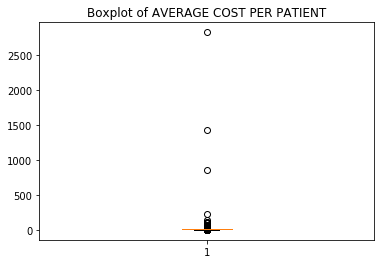

In [29]:
#do some checking before plotting

print(practice_level['NUMBER_OF_PATIENTS'].describe())
print(practice_level['AVERAGE_COST'].describe())

#Check the relative spend data - shows some extreme outliers
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.boxplot(practice_level['AVERAGE_COST'])
ax1.set_title("Boxplot of AVERAGE COST PER PATIENT")
plt.show()

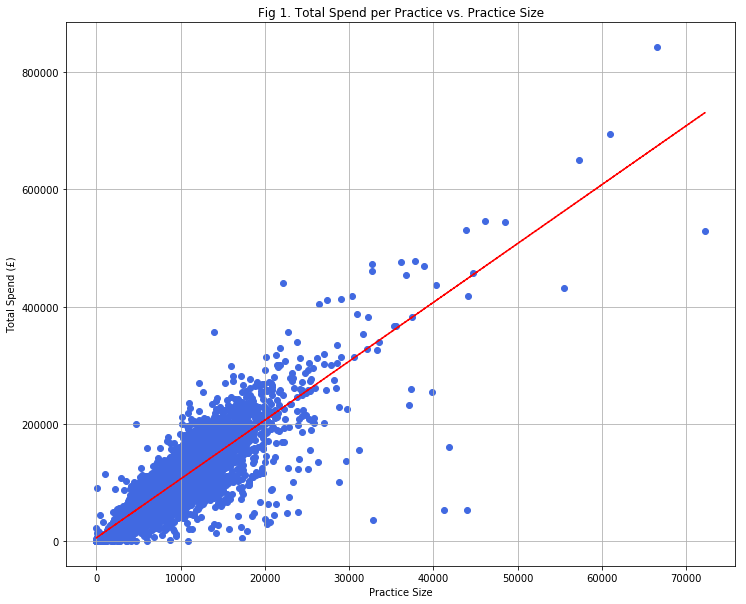

In [30]:
#Create scatter plot for total spend
x = practice_level['NUMBER_OF_PATIENTS']
y = practice_level['ACTCOST']

#create scatter plot and trend line for total spend
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.scatter(x, y, color='royalblue')
ax.grid(b=True)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

ax.set_title("Fig 1. Total Spend per Practice vs. Practice Size")
ax.set_ylabel("Total Spend (£)")
ax.set_xlabel("Practice Size")
plt.show()

(7176, 20)
(15, 4)


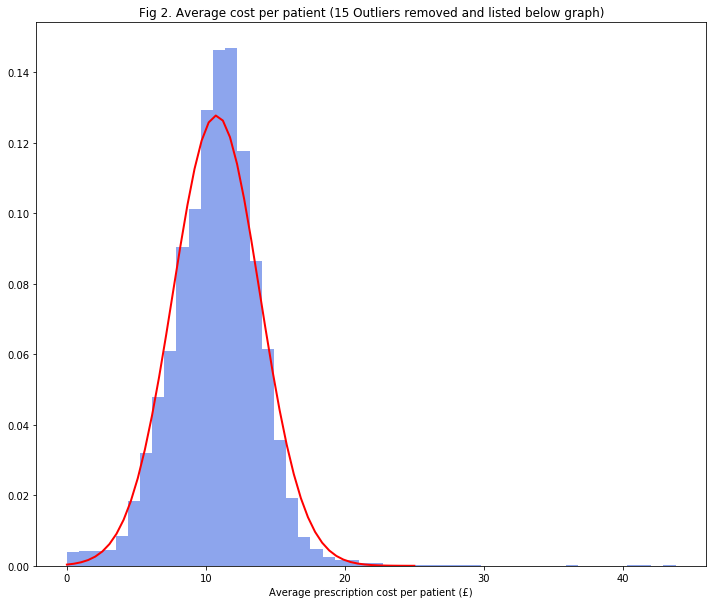

All 15 Practices with excessive levels of average spend per patient (>£50)


,PRACTICE_NAME,POSTCODE_x,ACTCOST,AVERAGE_COST
0,ROYAL HOSPITAL CHELSEA,SW3 4SR,14850.18,50.34
1,KEYHEALTH MEDICAL CENTRE,EN9 1NP,3099.81,221.42
2,NIGHTINGALE HOUSE,SW12 8NB,17924.38,97.95
3,DR GOULD AND AL-TIMMAN,LS7 3QB,892.19,68.63
4,H&R P C SPECIAL SCHEME,TN34 1BA,1037.85,103.78
5,THE HOMELESS HEALTHCARE TEAM,GL1 3NF,4626.12,57.83
6,SUSSEX DOWN AND WEALD SPECIAL SCHEME,BN22 8DR,755.39,50.36
7,SAWBRIDGEWORTH MEDICAL SERVICES,CM21 0HH,90691.01,855.58
8,VERNOVA HEALTHCARE CIC,SK11 6JL,22640.16,2830.02
9,LCD WAKEFIELD WIC,WF1 2SN,7793.03,63.88


In [31]:
#Create histogram for Relative Spend
#Boxplot above shows some extreme outliers, these are removed first
practice_level_low = practice_level[practice_level['AVERAGE_COST'] <= 50]
print(practice_level_low.shape)
practice_level_high = practice_level[practice_level['AVERAGE_COST'] > 50]
practice_level_high = practice_level_high[['PRACTICE_NAME','POSTCODE_x', 'ACTCOST', 'AVERAGE_COST']]
print(practice_level_high.shape)

x=practice_level_low['AVERAGE_COST']
mu, std = norm.fit(x)

fig = plt.figure(figsize=(12,10), )
ax = fig.add_subplot(111)
ax.hist(x, color='royalblue', bins=50, density=True, alpha=0.6)

x = np.linspace(0,25)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2, color='r')
ax.set_xlabel("Average prescription cost per patient (£)")
ax.set_title("Fig 2. Average cost per patient (15 Outliers removed and listed below graph)")
plt.show()


print('\033[1m' + 'All 15 Practices with excessive levels of average spend per patient (>£50)' + '\033[0m')
noind = practice_level_high.reset_index(drop=True)
noind.head(20)

### Discussion - Total Costs and Relative costs for patients for all practices, April 2019

<html>
<font color='green' size=2> 
As may be expected, there seems to be a strong linear trend between total spending per practice and number of patients 
registered to the practice (Fig 1. above). The vast majority of practices have less than 30,000 patients registered and are under the £400,000 limit for total spend on prescriptions. However in spite of this trend, there seem to be some large variations in total spend between practices of similar size. While it may be tempting to try and compare practices of similar size with a large difference in spending, it should be noted that practices differ significantly in many ways, not just number of patients registered. For example the age profile and soci-economic status of the sub-populations that practices serve may be completely different. This would lead to different disease and treatment profiles for different practices. This is a limitation of the data provided as we cannot drill down to find data on factors like age profile and socio-economic status for practices. If more information is required, it may be possible to link to, for example, data on socio-economic status using the practice postcode. This may help in comparing practices. However all such drilling down into the data should be cognizant of the various issues with patient confidentiality and data ethics.<br><br>

Fig 2. above shows average cost per patient once 15 outliers have been removed (these are listed below Fig. 2). 
The distribution of cost once outliers have been removed is largely normal. In this case, somewhat arbitrarily an outlier is considered to be any average spend per patient over £50. This seems reasonable since the average prescribing cost per patient (for April 2018) is about the £11 mark judging from Fig. 2.
Looking at the outliers, some practices have very large average costs per patient, it would definitely be worth examining the data for these practices in more detail to see if there is any reason for the large average spend.
</font>
</html>

# Assignment B

<html>
<font color='green' size=2>
<bold>Overview</bold> <br><br>
WHO Mortality data were downloaded from https://www.who.int/healthinfo/mortality_data/en/. The data records the cause of death (by ICD code) for various countries for various years. In addition to the mortality data there are two files that enable lookup of country names and country population for various years. Total deaths in 2010 were reported for Iceland, Italy and New Zealand. Distribution of death for all years was reported for Italy as were the top 5 causes of death from neoplasm. Neoplasm deaths for Australia in 2010 were reported and compared with Italy.
</font>
</html>

## 0. Data checking and Cleaning

In [32]:
#Read in raw data files for WHO mortality data

#ICD mortality data part 1
url = 'https://www.who.int/healthinfo/statistics/Morticd10_part1.zip?ua=1'
mortality1 = pd.read_csv(url, encoding = "ISO-8859-1", compression='zip', low_memory=False)
#ICD mortality data part 2
url = 'https://www.who.int/healthinfo/statistics/Morticd10_part2.zip?ua=1'
mortality2 = pd.read_csv(url, encoding = "ISO-8859-1", compression='zip', low_memory=False)
#Country information
url = 'https://www.who.int/healthinfo/statistics/country_codes.zip?ua=1'
country_codes = pd.read_csv(url, encoding = "ISO-8859-1", compression='zip')
#Population information
url = 'https://www.who.int/healthinfo/Pop.zip?ua=1'
population = pd.read_csv(url, encoding = "ISO-8859-1", compression='zip')

#concatenate mortality data
print(mortality1.shape)
print(mortality2.shape)
mortality = pd.concat([mortality1, mortality2])

(1388106, 39)
(2316790, 39)


In [33]:
#check mortality data - uses examine function defined in Assignment A
examine(mortality)
mortality.head(5)

(3704896, 39)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3704896 entries, 0 to 2316789
Data columns (total 39 columns):
Country       3704896 non-null int64
Admin1        84173 non-null float64
SubDiv        2707 non-null object
Year          3704896 non-null int64
List          3704896 non-null object
Cause         3704896 non-null object
Sex           3704896 non-null int64
Frmat         3704896 non-null int64
IM_Frmat      3704896 non-null int64
Deaths1       3704896 non-null int64
Deaths2       3702654 non-null float64
Deaths3       3702654 non-null float64
Deaths4       3537648 non-null float64
Deaths5       3537648 non-null float64
Deaths6       3537648 non-null float64
Deaths7       3702654 non-null float64
Deaths8       3699669 non-null float64
Deaths9       3702654 non-null float64
Deaths10      3699669 non-null float64
Deaths11      3702654 non-null float64
Deaths12      3699669 non-null float64
Deaths13      3702654 non-null float64
Deaths14      3699669 non-null floa

,Country,Admin1,SubDiv,Year,List,Cause,Sex,Frmat,IM_Frmat,Deaths1,...,Deaths21,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4
0,1400,NaN,NaN,2001,101,1000,1,7,8,332,...,95.0,NaN,NaN,NaN,NaN,0.0,8.0,NaN,NaN,NaN
1,1400,NaN,NaN,2001,101,1000,2,7,8,222,...,112.0,NaN,NaN,NaN,NaN,0.0,11.0,NaN,NaN,NaN
2,1400,NaN,NaN,2001,101,1001,1,7,8,24,...,5.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,1400,NaN,NaN,2001,101,1001,2,7,8,14,...,6.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,1400,NaN,NaN,2001,101,1002,1,7,8,0,...,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN


In [34]:
examine(country_codes)

(227, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 2 columns):
country    227 non-null int64
name       227 non-null object
dtypes: int64(1), object(1)
memory usage: 3.6+ KB
None
         count         mean          std     min     25%     50%     75%  \
country  227.0  2893.612335  1266.697507  1010.0  1565.0  3050.0  4095.0   

            max  
country  5207.0  
     count unique                   top freq
name  227   227    Germany, West Berlin  1  


,country,name
0,1010,Algeria
1,1020,Angola
2,1025,Benin
3,1030,Botswana
4,1035,Burkina Faso


In [35]:
#tidy up country codes data

#capitalise name of country to make compatible with mortality data
country_codes.rename(columns = {'country':'Country'}, inplace=True)
country_codes.head(1)

,Country,name
0,1010,Algeria


In [36]:
#check population data
examine(population)

#for each country, 2 population records for every year for male and female

(9383, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9383 entries, 0 to 9382
Data columns (total 33 columns):
Country    9383 non-null int64
Admin1     82 non-null float64
SubDiv     138 non-null object
Year       9383 non-null int64
Sex        9383 non-null int64
Frmat      9383 non-null int64
Pop1       9383 non-null float64
Pop2       9247 non-null float64
Pop3       9247 non-null float64
Pop4       5178 non-null float64
Pop5       5178 non-null float64
Pop6       5178 non-null float64
Pop7       9247 non-null float64
Pop8       9229 non-null float64
Pop9       9247 non-null float64
Pop10      9229 non-null float64
Pop11      9247 non-null float64
Pop12      9229 non-null float64
Pop13      9247 non-null float64
Pop14      9229 non-null float64
Pop15      9247 non-null float64
Pop16      9229 non-null float64
Pop17      9247 non-null float64
Pop18      9229 non-null float64
Pop19      9247 non-null float64
Pop20      9185 non-null float64
Pop21      9091 non-null float64
Pop

,Country,Admin1,SubDiv,Year,Sex,Frmat,Pop1,Pop2,Pop3,Pop4,...,Pop18,Pop19,Pop20,Pop21,Pop22,Pop23,Pop24,Pop25,Pop26,Lb
0,1060,NaN,NaN,1980,1,7,137100.0,3400.0,15800.0,NaN,...,NaN,5300.0,NaN,2900.0,NaN,NaN,NaN,NaN,6500.0,5000.0
1,1060,NaN,NaN,1980,2,7,159000.0,4000.0,18400.0,NaN,...,NaN,6200.0,NaN,3400.0,NaN,NaN,NaN,NaN,7500.0,6000.0
2,1125,NaN,NaN,1955,1,2,5051500.0,150300.0,543400.0,NaN,...,110200.0,51100.0,41600.0,14300.0,11800.0,25300.0,NaN,NaN,0.0,253329.0
3,1125,NaN,NaN,1955,2,2,5049400.0,145200.0,551000.0,NaN,...,122100.0,51100.0,50700.0,15800.0,18000.0,28500.0,NaN,NaN,0.0,237901.0
4,1125,NaN,NaN,1956,1,2,5353700.0,158700.0,576600.0,NaN,...,116900.0,54100.0,44000.0,14900.0,12400.0,26600.0,NaN,NaN,0.0,250022.0


In [37]:
#merge mortality with country data to get country name - icd_country has all the valid death data for all years
icd_country = pd.merge(mortality, country_codes, how='inner', on='Country')

#check merge didn't lose information - should have the same number of rows after merge with inner option
print(mortality.shape)
print(icd_country.shape)

(3704896, 39)
(3704896, 40)


<html>
<font color='green' size=2>
<b><u>Description of data:</u></b><br><br>

<b>Mortality data</b> <br>

For various countries mortality data are recorded for various years using ICD code. Age groups distribution of deaths are also included. Not every country reports on age groups in the same way, and not every country uses the same level of ICD coding system (e.g. ICD 9 versus ICD 10). For each country, for each year for which data exists, the total deaths for males and females for each recorded cause (ICD10 code) is reported. For rare causes of death, it is possible that there is a record just for males, or vice versa. The column DEATHS1 (which has no missing values) reports the total deaths in each case.<br><br>

<b>Country lookup data</b> <br>

This dataset contains one record per country by which the country name is looked up from a country code field that exists in the mortality data. There are no missing values in this dataset.<br><br>

<b>Population lookup data</b> <br>

For various countries population data are recorded for various years. For each year for which data exists, there are two records reporting population for Males and Females. The column POP1 (which has no missing values) reports the total population in each case.
</font>
</html>

## 1. Population and Total Number of Deaths (all causes) for selected countries in 2010

In [38]:
#keep only the mortality data we need for 3 countries and 2010 data only
mortality_subset = icd_country[ (icd_country['name'].isin(['Iceland','Italy','New Zealand'])) & (icd_country['Year'] == 2010)]
print(mortality_subset.name.unique())
print(mortality_subset.Year.unique())
print(mortality_subset.shape)
mortality_subset.head()

['Iceland' 'Italy' 'New Zealand']
[2010]
(7382, 40)


,Country,Admin1,SubDiv,Year,List,Cause,Sex,Frmat,IM_Frmat,Deaths1,...,Deaths22,Deaths23,Deaths24,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4,name
2612934,4160,NaN,NaN,2010,103,A04,2,0,1,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Iceland
2612935,4160,NaN,NaN,2010,103,A05,2,0,1,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Iceland
2612936,4160,NaN,NaN,2010,103,A39,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Iceland
2612937,4160,NaN,NaN,2010,103,A41,1,0,1,5,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Iceland
2612938,4160,NaN,NaN,2010,103,A41,2,0,1,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Iceland


In [39]:
#merge with the population data
mortality_pop = pd.merge(mortality_subset, population, how='inner', on=['Country','Year', 'Sex'])
mortality_pop.sort_values(by=['Country','Cause','Sex'], inplace=True)

#check merge didn't lose information - should have the same number of rows after merge with inner option
print(mortality_subset.shape)
print(mortality_pop.shape)
mortality_pop.head()

(7382, 40)
(7382, 70)


,Country,Admin1_x,SubDiv_x,Year,List,Cause,Sex,Frmat_x,IM_Frmat,Deaths1,...,Pop18,Pop19,Pop20,Pop21,Pop22,Pop23,Pop24,Pop25,Pop26,Lb
0,4160,NaN,NaN,2010,103,A04,2,0,1,1,...,7536.0,5835.0,4448.0,4155.0,3374.0,2051.0,798.5,227.5,0.0,2384.0
1,4160,NaN,NaN,2010,103,A05,2,0,1,1,...,7536.0,5835.0,4448.0,4155.0,3374.0,2051.0,798.5,227.5,0.0,2384.0
163,4160,NaN,NaN,2010,103,A39,1,0,1,1,...,7880.0,5658.5,4143.5,3600.0,2577.0,1284.0,401.0,68.0,0.0,2523.0
164,4160,NaN,NaN,2010,103,A41,1,0,1,5,...,7880.0,5658.5,4143.5,3600.0,2577.0,1284.0,401.0,68.0,0.0,2523.0
2,4160,NaN,NaN,2010,103,A41,2,0,1,3,...,7536.0,5835.0,4448.0,4155.0,3374.0,2051.0,798.5,227.5,0.0,2384.0


In [40]:
#check against above - correct population figures for Iceland 2010
pop_iceland_2010 = population[ (population['Country'] == 4160) & (population['Year'] == 2010)]
pop_iceland_2010

,Country,Admin1,SubDiv,Year,Sex,Frmat,Pop1,Pop2,Pop3,Pop4,...,Pop18,Pop19,Pop20,Pop21,Pop22,Pop23,Pop24,Pop25,Pop26,Lb
5951,4160,NaN,NaN,2010,1,0,159971.0,2529.0,2483.5,2412.0,...,7880.0,5658.5,4143.5,3600.0,2577.0,1284.0,401.0,68.0,0.0,2523.0
5952,4160,NaN,NaN,2010,2,0,158070.0,2409.0,2380.5,2271.0,...,7536.0,5835.0,4448.0,4155.0,3374.0,2051.0,798.5,227.5,0.0,2384.0


In [41]:
#merge population data with country code to get country name
country_pop = pd.merge(population, country_codes, how='inner', on='Country')
print(population.shape)
print(country_pop.shape)

#create a function to give pop and death data
def pop_deaths(country):
    pop = country_pop[(country_pop['name'] == country) & (country_pop['Year'] == 2010)]
    total_pop = int(pop.groupby('Year')['Pop1'].sum().reset_index().iloc[0]['Pop1'])
    death = mortality_pop[(mortality_pop['name'] == country)]
    total_death = death['Deaths1'].sum()
    print (country, " : Population - " + str(total_pop) + " Deaths - " + str(total_death) + " Rate:", round(total_death/total_pop*100,2))
   
pop_deaths('Iceland')
pop_deaths('Italy') 
pop_deaths('New Zealand')

(9383, 33)
(9383, 34)
Iceland  : Population - 318041 Deaths - 4038 Rate: 1.27
Italy  : Population - 60483386 Deaths - 1169230 Rate: 1.93
New Zealand  : Population - 4367360 Deaths - 57298 Rate: 1.31


<h3><center> Table 5 - Population and Deaths for selected countries, 2010 </h3></center>

|&emsp;|  |  |  |
| --- | --- | --- | --- | --- | 
|__Country__ | __Population__ | __Total Deaths__ |  __Death Rate__ |
|Iceland |  318,041 | 4,038 | 1.27%|
|Italy |  60,483,386 | 1,169,230 | 1.93%|
|New Zealand |  4,367,360 | 57,298 | 1.31%|

### Discussion - Population and Deaths for selected countries, 2010

<html>
<font color='green' size=2>
For 2010, it appears that while Iceland and New Zealand have similar death rates, calculated as total deaths as a percentage of population (1.27% vs. 1.31% resprectively), Italy has a substantially higher death rate of 1.93%
</font>
</html>

## 2. Distribution of deaths by age group in Italy

In [42]:
#function to sum deaths by age group for a dataframe - assumes a format of 00 - data in all age categories
def death_by_age(df):
    
    df = df.copy(deep=True)
    
    #keep only columns that have deaths split by age groups
    filter_col = [col for col in df if col.startswith('Deaths')]
    #drop the column that has deaths by all ages
    df = df[filter_col].drop('Deaths1', axis=1)
    
    #rename column names for subsequent display
    new_col_names = ['Deaths at age 0 year',\
    'Deaths at age 1 year',\
    'Deaths at age 2 years',\
    'Deaths at age 3 years',\
    'Deaths at age 4 years',\
    'Deaths at age 5-9 years',\
    'Deaths at age 10-14 years',\
    'Deaths at age 15-19 years',\
    'Deaths at age 20-24 years',\
    'Deaths at age 25-29 years',\
    'Deaths at age 30-34 years',\
    'Deaths at age 35-39 years',\
    'Deaths at age 40-44 years',\
    'Deaths at age 45-49 years',\
    'Deaths at age 50-54 years',\
    'Deaths at age 55-59 years',\
    'Deaths at age 60-64 years',\
    'Deaths at age 65-69 years',\
    'Deaths at age 70-74 years',\
    'Deaths at age 75-79 years',\
    'Deaths at age 80-84 years',\
    'Deaths at age 85-89 years',\
    'Deaths at age 90-94 years',\
    'Deaths at age 95 years and above' ,\
    'Deaths at age unspecified']

    df.columns = new_col_names
    df = df.sum(axis=0).reset_index()
    df.columns=['agegroup', 'numdeaths']
    
    return df

(63356, 40)
(63356, 39)
0    63356
Name: Frmat, dtype: int64
2003    5018
2004    4909
2005    4824
2006    4845
2007    4838
2008    4903
2009    4999
2010    4970
2011    4884
2012    4910
2013    4876
2014    4643
2015    4737
Name: Year, dtype: int64


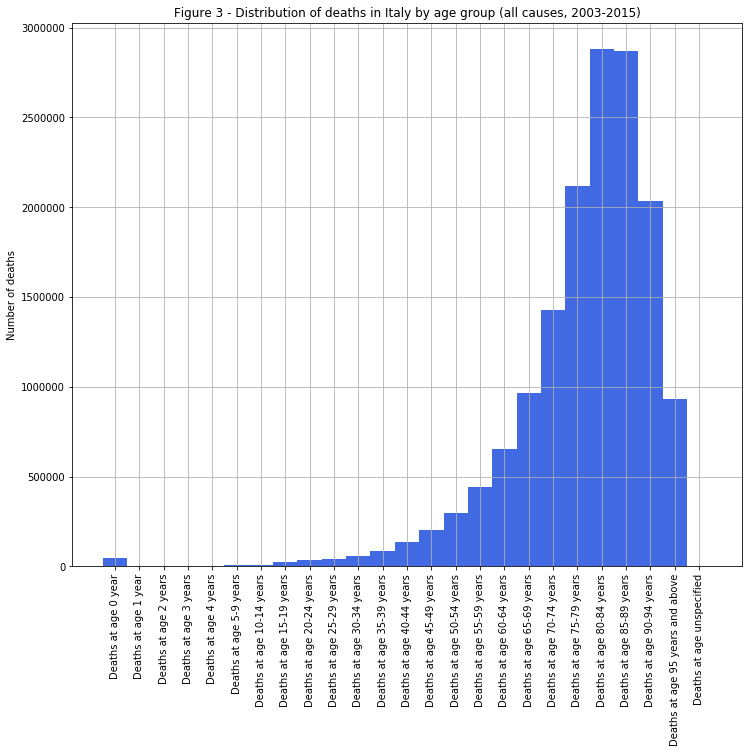

In [43]:
#get data for Italy - all years
italy_data = icd_country[icd_country['name'] == 'Italy']
print(italy_data.shape)

#check Italy data is right another way
italy_data2 = mortality[mortality['Country'] == 4180]
print(italy_data2.shape)

#check formats are consistent for this country
print(italy_data['Frmat'].value_counts())

#how many years
print(italy_data['Year'].value_counts().sort_index())


#use function defined above to get total deaths for all age groups
italy_death_data_all=death_by_age(italy_data)

#show graphically
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
ax.set_title("Figure 3 - Distribution of deaths in Italy by age group (all causes, 2003-2015)")
ax.bar(italy_death_data_all['agegroup'], italy_death_data_all['numdeaths'], width=1.0, color="royalblue")
ax.set_ylabel("Number of deaths")
ax.grid(b=True)
plt.xticks(rotation=90)
plt.show()

### Discussion - Deaths by age group in Italy for all years 

<html>
<font color='green' size=2>
After a significant blip indicating infant mortality deaths (deaths of infants under 1 year old), the total number of deaths in Italy falls, then starts rising about age 15-19. From that point on the rise in total deaths from all causes is roughly exponential for each age-group with a growing number of deaths for each increasing age-group. This reaches a peak at the 80-89 years old age-groups before a sharp fall at the 90-94 age-group. This latter fall probably reflects the fact that the proportion of 90+ people in Italy (as in other countries) is quite small.
</font>
</html>

## 3. Top 5 Causes of death in Italy for Neoplasm category C00-D48

In [44]:
#function to get Neoplasm causes of death only
def get_neoplasms(df):
    
    df=df.copy(deep=True)
    
    #create new columns that split the ICD10 code into useful values for subsequent checking
    df['first'] = df['Cause'].str[0]
    df['second_third'] = df['Cause'].str[1:3]
    df['second_third_num'] = df['second_third'].apply(lambda x: int(x) if x.isdigit() else 9999)

    #get the data that relate to ICD codes C00-D48 - all codes starting with C are Neoplasms, as are all starting from D00-D48
    df = df[(df['first'] == 'C') | ( (df['first'] == 'D') & (df['second_third_num'] < 49))]
    return df

In [45]:
#suppress non-useful warning
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', -1)

#use function defined earlier to get Neoplasm deaths for Italy (all years)
italy_neoplasm_deaths = get_neoplasms(italy_data)

#check we have got all the neoplasm deaths
#print(italy_neoplasm_deaths.Cause)

#sum all Neoplasm deaths by ICD-10 code
italy_neoplasm_count = italy_neoplasm_deaths.groupby('Cause')['Deaths1'].sum().reset_index()
italy_neoplasm_count.sort_values('Deaths1', ascending=False, inplace=True)


#originally a lookup file was used to lookup the description, but this seemed inaccurate
#therefore the following code was replaced by a manual lookup

# #get an ICD code-lookup file - obtained from http://www.cms.hhs.gov/ICD10/downloads/Dxgem_2009.zip
# #merge with Italian neoplasm count to get ICD terms (descriptions)
# icd_lookup=pd.read_csv("C:/DMHR assignment/ICD10/ICD10_lookup.csv")
# icd_lookup.columns = ['temp','description']
# icd_lookup['Cause'] = icd_lookup['temp'].str[0:4]
# icd_lookup.drop_duplicates(['Cause'], inplace=True)
# icd_lookup.drop('temp', axis=1, inplace=True)

# #merge to get ICD description term - this is not perfect due to lookup file
# italy_neoplasm_count_icd = pd.merge(italy_neoplasm_count, icd_lookup, how='left', on='Cause')

# #check merge
# print(italy_neoplasm_count.shape)
# print(italy_neoplasm_count_icd.shape)
# print(italy_neoplasm_count_icd.head())


#ICD description manually set
italy_neoplasm_count['icd_desc'] = "Other"
italy_neoplasm_count.iloc[0,2] = "Malignant neoplasm of unspecified part of unspecified bronchus or lung"
italy_neoplasm_count.iloc[1,2] = "Malignant neoplasm of breast of unspecified site"
italy_neoplasm_count.iloc[2,2] = "Malignant neoplasm of colon, unspecified"
italy_neoplasm_count.iloc[3,2] = "Malignant neoplasm of stomach, unspecified"
italy_neoplasm_count.iloc[4,2] = "Malignant neoplasm of pancreas, unspecified"

#Split the dataset into top 5 and the rest
top = italy_neoplasm_count[italy_neoplasm_count['Deaths1'] >= italy_neoplasm_count.iloc[4,1]]
bottom = italy_neoplasm_count[italy_neoplasm_count['Deaths1'] < italy_neoplasm_count.iloc[4,1]]
print(top.shape)
print(bottom.shape)

#sum the bottom category and append to top
other_total = bottom["Deaths1"].sum()
other_df = {'Cause': "Other", 'Deaths1': other_total, 'icd_desc': "Other neoplasms"}
italy_neoplasm_count_group = top.append(other_df, ignore_index=True)

#get the proportion of total         
italy_neoplasm_count_group['percent'] = italy_neoplasm_count_group['Deaths1'].apply(lambda x: (x/sum(italy_neoplasm_count_group['Deaths1'])) *100)
italy_neoplasm_count_group.head(10)

(5, 3)
(615, 3)


,Cause,Deaths1,icd_desc,percent
0,C349,426451,Malignant neoplasm of unspecified part of unspecified bronchus or lung,18.964664
1,C509,155895,Malignant neoplasm of breast of unspecified site,6.932792
2,C189,143188,"Malignant neoplasm of colon, unspecified",6.367701
3,C169,125679,"Malignant neoplasm of stomach, unspecified",5.589059
4,C259,120070,"Malignant neoplasm of pancreas, unspecified",5.339622
5,Other,1277378,Other neoplasms,56.806162


<h3><center> Table 6 - Deaths from Neoplasm in Italy (2003-2015) </center></h3>

|&emsp;|  |  |  |
| --- | --- | --- | --- | --- | 
|__ICD10 Code__ | __Description__ | __Total Deaths__ | __% of Neoplasm deaths__ |
|C349 |  Malignant neoplasm of unspecified part of unspecified bronchus or lung  | 426,451 | 19.0% |
|C509 |  Malignant neoplasm of breast of unspecified site   | 155,895 | 6.9% |
|C189 |  Malignant neoplasm of colon, unspecified    | 143,188 | 6.4% |
|C169 |  Malignant neoplasm of stomach, unspecified    | 125,679 | 5.6% |
|C259 |  Malignant neoplasm of pancreas, unspecified     | 120070 | 5.3% |
|Other |  All other neoplasms     | 1,277,378 | 56.8% |

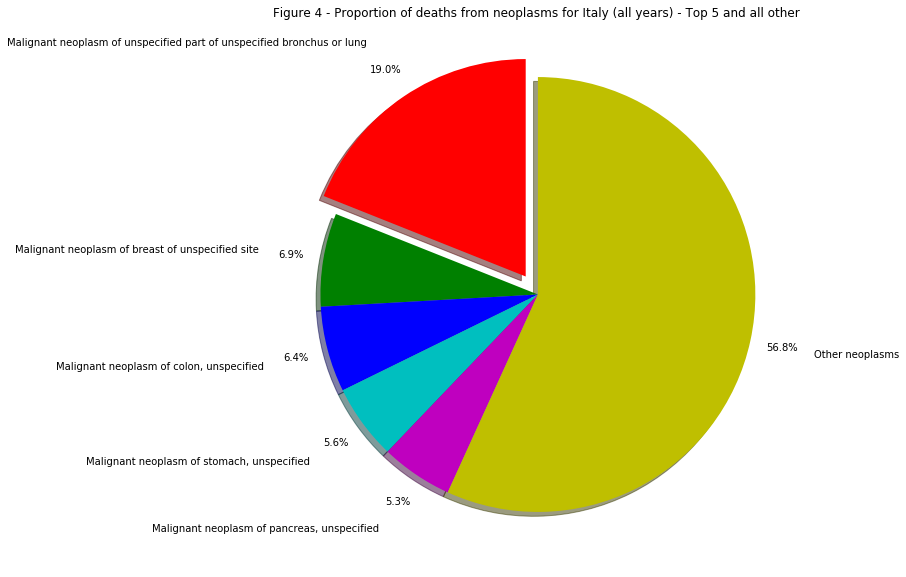

In [46]:
#create a piechart to visualise the table above
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
#colours = ['#C7B299', '#A67C52', '#C69C6E', '#754C24', '#534741', '#754C24']
colours=list('rgbcmy')
explode = [0.1, 0, 0, 0, 0, 0]
ax.axis('equal')        
ax.pie(italy_neoplasm_count_group['percent'], colors=colours, shadow=True, startangle=90,
       explode=explode, labels=italy_neoplasm_count_group['icd_desc'], autopct='%.1f%%',
       pctdistance=1.15, labeldistance=1.3)
ax.set_title("Figure 4 - Proportion of deaths from neoplasms for Italy (all years) - Top 5 and all other ")
plt.show()

### Discussion - Deaths from Neoplasm in Italy (2003-2015)

<html>
<font color='green' size=2>
As can be seen in Table 6 and Figure 4 above, lung cancer is by far the most common cause of cancer death in Italy for the years 2003-2015 with a proportion of 19% of all cancer deaths, followed by breast cancer, colon cancer, stomach cancer and pancreatic cancer in that order. With the second largest cuase of cancer deaths, breast cancer, at about 7%, the difference between the first and second cause of death is quite dramatic. These top 5 cancer deaths make up about 43% of all cancer deaths in Italy. This has implications for which cancers are targeted for treatment research with limited resources available - if a focus is made on the top 5 death-causing cancers and especially, lung cancer, more lives could be saved than targeting other "lesser" neoplasms.
</font>
</html>

## 4. Deaths by age group for Neoplasms in Australia, 2010

In [47]:
#get Neoplasm deaths data for Australia in 2010
australia_data_2010 = icd_country[(icd_country['name'].isin(['Australia'])) & (icd_country['Year'] == 2010)]

#use function defined earlier to get Neoplasm deaths for Australia (2010)
australia_neoplasm_deaths_2010 = get_neoplasms(australia_data_2010)

#check we have got all the neoplasm deaths
#print(australia_neoplasm_deaths_2010.Cause)

#use function defined earlier to sum deaths by age groups
australia_neoplasm_deaths_2010_age=death_by_age(australia_neoplasm_deaths_2010)

ordered = australia_neoplasm_deaths_2010_age.sort_values('numdeaths', ascending=False)
print(ordered.head(5))

                     agegroup  numdeaths
20  Deaths at age 80-84 years  7167.0   
19  Deaths at age 75-79 years  6291.0   
18  Deaths at age 70-74 years  5713.0   
21  Deaths at age 85-89 years  5520.0   
17  Deaths at age 65-69 years  4768.0   


<h3><center> Table 7 -  Top 5 age groups dying from Neoplasms in Australia, 2010 </center></h3>

|&emsp;|  |
| --- | --- | 
|__Age group__| __Number of deaths__ |
|Deaths at age 80-84 years | 7167  | 
|Deaths at age 75-79 years | 6291  | 
|Deaths at age 70-74 years | 5713  | 
|Deaths at age 85-89 years | 5520  | 
|Deaths at age 65-69 years | 4768  | 

### Discussion - Top 5 age groups dying from Neoplasms in Australia, 2010

<html>
<font color='green' size=2>
Looking at table 7 above, as one might expect the top 5 age-groups dying from cancer in Australia in terms of total numbers are in the elderly age-group ranging from 65-89. There is a marked fall in total deaths from cancer after the age of 84, with cancer deaths falling in the next age-group 85-89. This pattern is slightly different to what we found above in the pattern of all deaths in Italy where the total deaths fell markedly only in the next age-group 90-94 (Fig. 3 above). It may be worth investigating this anomaly - perhaps the proportion of deaths by different causes changes from the age-groups 85-89 to 90-94.
</font>
</html>

## 5. Comparing frequency of Neoplasm deaths in Italy and Australia, 2010

In [48]:
#get Neoplasm deaths data for Italy in 2010
italy_data_2010 = icd_country[(icd_country['name'].isin(['Italy'])) & (icd_country['Year'] == 2010)]

#check format is the same - age groups reported the same
print(italy_data_2010['Frmat'].value_counts())
print(australia_data_2010['Frmat'].value_counts())

#use function defined earlier to get Neoplasm deaths for Italy (2010)
italy_neoplasm_deaths_2010 = get_neoplasms(italy_data_2010)

#check we have got all the neoplasm deaths
#print(italy_neoplasm_deaths_2010.Cause)

#use function defined earlier to sum deaths by age groups
italy_neoplasm_deaths_2010_age=death_by_age(italy_neoplasm_deaths_2010)

#get population data for 2010 for Australia and Italy and append to dataframe to get death rates per age group
italy_pop_2010 = country_pop[(country_pop['name'] == 'Italy') & (country_pop['Year'] == 2010)]['Pop1'].sum()
australia_pop_2010 = country_pop[(country_pop['name'] == 'Australia') & (country_pop['Year'] == 2010)]['Pop1'].sum()

#overall deathrate for each country - total neoplasms divided by population
italy_neoplasm_deaths_2010_age['pop'] = italy_pop_2010
italy_neoplasm_deaths_2010_age['deathrate'] = italy_neoplasm_deaths_2010_age['numdeaths']/italy_neoplasm_deaths_2010_age['pop']*100

australia_neoplasm_deaths_2010_age['pop'] = australia_pop_2010
australia_neoplasm_deaths_2010_age['deathrate'] = australia_neoplasm_deaths_2010_age['numdeaths']/australia_neoplasm_deaths_2010_age['pop']*100

italy_neoplasm_deaths_2010.head()

0    4970
Name: Frmat, dtype: int64
0    3777
Name: Frmat, dtype: int64


,Country,Admin1,SubDiv,Year,List,Cause,Sex,Frmat,IM_Frmat,Deaths1,...,Deaths25,Deaths26,IM_Deaths1,IM_Deaths2,IM_Deaths3,IM_Deaths4,name,first,second_third,second_third_num
2652668,4180,NaN,NaN,2010,104,C000,1,0,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,Italy,C,00,0
2652669,4180,NaN,NaN,2010,104,C000,2,0,1,4,...,2.0,0.0,0.0,0.0,0.0,0.0,Italy,C,00,0
2652670,4180,NaN,NaN,2010,104,C001,1,0,1,17,...,1.0,0.0,0.0,0.0,0.0,0.0,Italy,C,00,0
2652671,4180,NaN,NaN,2010,104,C001,2,0,1,10,...,0.0,0.0,0.0,0.0,0.0,0.0,Italy,C,00,0
2652672,4180,NaN,NaN,2010,104,C006,1,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,Italy,C,00,0


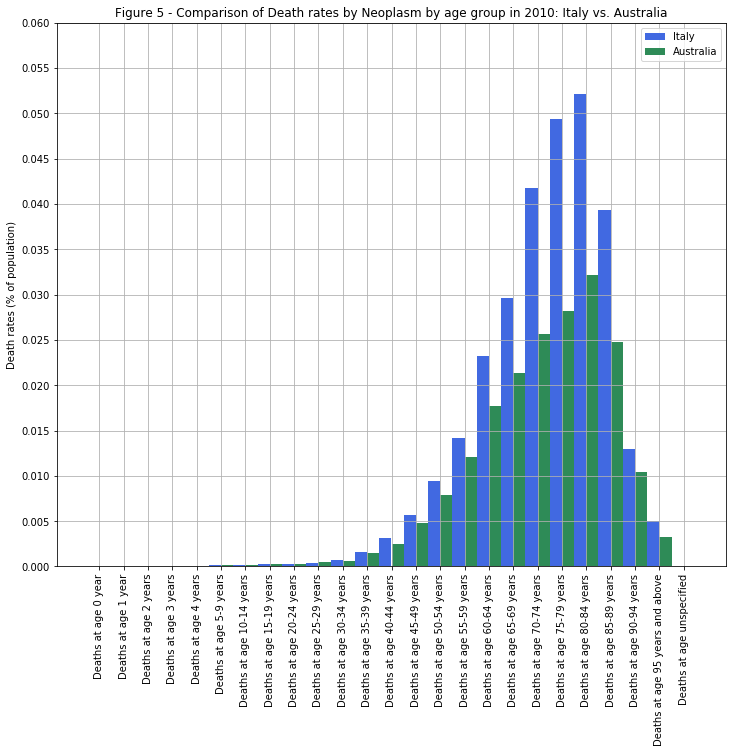

In [49]:
#create side by side bar plots for age related Neoplasm death rates (% of population), Italy versus Australia 2010
N = 25
index = np.arange(N)
width = 0.5      # the width of the bars

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
rects1 = ax.bar(index, italy_neoplasm_deaths_2010_age['deathrate'], width, color='royalblue')
rects2 = ax.bar(index + width, australia_neoplasm_deaths_2010_age['deathrate'], width, color='seagreen')

ax.set_ylabel('Death rates (% of population)')
ax.set_title('Figure 5 - Comparison of Death rates by Neoplasm by age group in 2010: Italy vs. Australia')
ax.set_xticks(index + width / 2)
ax.set_xticklabels( ('Deaths at age 0 year',\
    'Deaths at age 1 year',\
    'Deaths at age 2 years',\
    'Deaths at age 3 years',\
    'Deaths at age 4 years',\
    'Deaths at age 5-9 years',\
    'Deaths at age 10-14 years',\
    'Deaths at age 15-19 years',\
    'Deaths at age 20-24 years',\
    'Deaths at age 25-29 years',\
    'Deaths at age 30-34 years',\
    'Deaths at age 35-39 years',\
    'Deaths at age 40-44 years',\
    'Deaths at age 45-49 years',\
    'Deaths at age 50-54 years',\
    'Deaths at age 55-59 years',\
    'Deaths at age 60-64 years',\
    'Deaths at age 65-69 years',\
    'Deaths at age 70-74 years',\
    'Deaths at age 75-79 years',\
    'Deaths at age 80-84 years',\
    'Deaths at age 85-89 years',\
    'Deaths at age 90-94 years',\
    'Deaths at age 95 years and above' ,\
    'Deaths at age unspecified') )

ax.legend( (rects1[0], rects2[0]), ('Italy', 'Australia'))
ax.grid(b=True)
plt.yticks(np.arange(0, max(italy_neoplasm_deaths_2010_age['deathrate']+.01), 0.005))
plt.xticks(rotation=90)
plt.show()

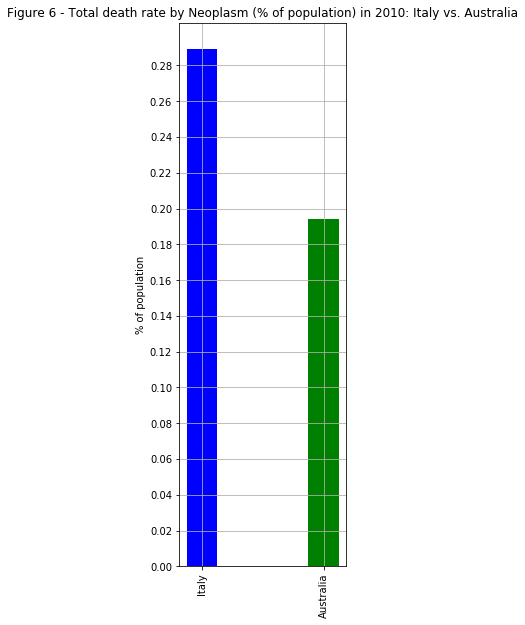

In [50]:
#find out total death rate for Neoplasm (% of population), Italy versus Australia, 2010

total_italy_neoplasm_2010 = italy_neoplasm_deaths_2010['Deaths1'].sum()
total_australia_neoplasm_2010 = australia_neoplasm_deaths_2010['Deaths1'].sum()

total_deaths_2010 = pd.DataFrame(columns=['country','tot_neoplasm_deaths_2010','pop_2010'])
total_deaths_2010.loc[1] = ['Italy', total_italy_neoplasm_2010, italy_pop_2010]
total_deaths_2010.loc[2] = ['Australia', total_australia_neoplasm_2010, australia_pop_2010]
total_deaths_2010['total_rate'] = total_deaths_2010['tot_neoplasm_deaths_2010']/total_deaths_2010['pop_2010']*100

fig = plt.figure(figsize=(3,10))
ax = fig.add_subplot(111)
ax.set_title("Figure 6 - Total death rate by Neoplasm (% of population) in 2010: Italy vs. Australia")
ax.bar(total_deaths_2010['country'], total_deaths_2010['total_rate'], color=list('bgkym') ,width=0.25)
ax.grid(b=True)
ax.set_ylabel("% of population")
plt.yticks(np.arange(0, max(total_deaths_2010['total_rate']+.01), 0.02))
plt.xticks(rotation=90)
plt.show()


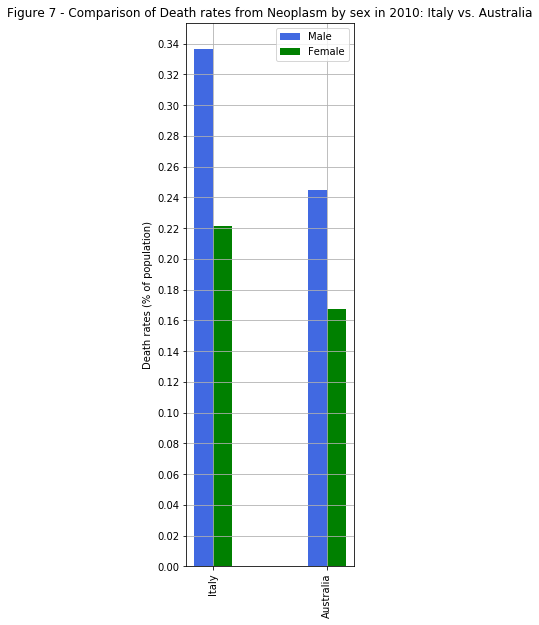

In [51]:
#death rate by sex for Italy and Australia

#italy
italy_deaths = pdsql("select name, Sex, sum(Deaths1) as deaths from italy_neoplasm_deaths_2010 group by name, Sex order by Sex")
italy_pop = pdsql ("select name, Sex, Pop1 from country_pop where name='Italy' and Year=2010")
italy_sex_rate =  pd.merge(italy_deaths, italy_pop, how='inner', on=['name','Sex'])
italy_sex_rate['death_rate'] = italy_sex_rate['deaths']/italy_sex_rate['Pop1']*100

#australia
australia_deaths = pdsql("select name, Sex, sum(Deaths1) as deaths from australia_neoplasm_deaths_2010 group by name, Sex order by Sex")
australia_pop = pdsql ("select name, Sex, Pop1 from country_pop where name='Australia' and Year=2010")
australia_sex_rate =  pd.merge(australia_deaths, australia_pop, how='inner', on=['name','Sex'])
australia_sex_rate['death_rate'] = australia_sex_rate['deaths']/australia_sex_rate['Pop1']*100

#create bar plot for sex differences

fig = plt.figure(figsize=(3,10))
ax = fig.add_subplot(111)
ax.set_ylabel('Death rates (% of population)')
ax.set_title('Figure 7 - Comparison of Death rates from Neoplasm by sex in 2010: Italy vs. Australia')

index = np.array([0,3])
width = 0.5      # the width of the bars
rects1 = ax.bar(index, italy_sex_rate['death_rate'], width, color='royalblue')
rects2 = ax.bar(index+width, australia_sex_rate['death_rate'], width, color='green')

ax.set_xticks(index + width / 2)
ax.set_xticklabels( ('Italy', 'Australia') )
ax.legend( (rects1[0], rects2[0]), ('Male', 'Female'))
ax.grid(b=True)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, max(italy_sex_rate['death_rate']+.01), 0.02))
plt.show()

In [52]:
#function to get top 5 causes of death
def top_5(df):
    
    df = df.copy(deep=True)
    
    df2 = df.groupby('Cause')['Deaths1'].sum().reset_index()
    df2.sort_values('Deaths1', ascending=False, inplace=True)
    
    top = df2[df2['Deaths1'] >= df2.iloc[4,1]]
    bottom = df2[df2['Deaths1'] < df2.iloc[4,1]]
    print(top.shape)
    print(bottom.shape)
    
    #sum the bottom category and append to top
    other_total = bottom["Deaths1"].sum()
    other_df = {'Cause': "Other", 'Deaths1': other_total, 'icd_desc': "Other neoplasms"}
    df4 = top.append(other_df, ignore_index=True)
    
    #get the proportion of total         
    df4['percent'] = df4['Deaths1'].apply(lambda x: (x/sum(df4['Deaths1'])) *100)
    return df4   

In [55]:
#Top 5 death causes from Neoplasm in Italy and Australia, 2010

#italy
#description looked up manually
italy_top5_2010 = top_5(italy_neoplasm_deaths_2010)
italy_top5_2010.iloc[0,2] = "Malignant neoplasm of unspecified part of unspecified bronchus or lung"
italy_top5_2010.iloc[1,2] = "Malignant neoplasm of breast of unspecified site"
italy_top5_2010.iloc[2,2] = "Malignant neoplasm of colon, unspecified"
italy_top5_2010.iloc[3,2] = "Malignant neoplasm of pancreas, unspecified"
italy_top5_2010.iloc[4,2] = "Malignant neoplasm of stomach, unspecified"

#australia
#description looked up manually
australia_top5_2010 = top_5(australia_neoplasm_deaths_2010)
australia_top5_2010.iloc[0,2] = "Malignant neoplasm of unspecified part of unspecified bronchus or lung"
australia_top5_2010.iloc[1,2] = "Malignant neoplasm of prostate"
australia_top5_2010.iloc[2,2] = "Malignant neoplasm of breast of unspecified site"
australia_top5_2010.iloc[3,2] = "Malignant neoplasm without specification of site"
australia_top5_2010.iloc[4,2] = "Malignant neoplasm of pancreas, unspecified"


(5, 2)
(444, 2)
(5, 2)
(331, 2)


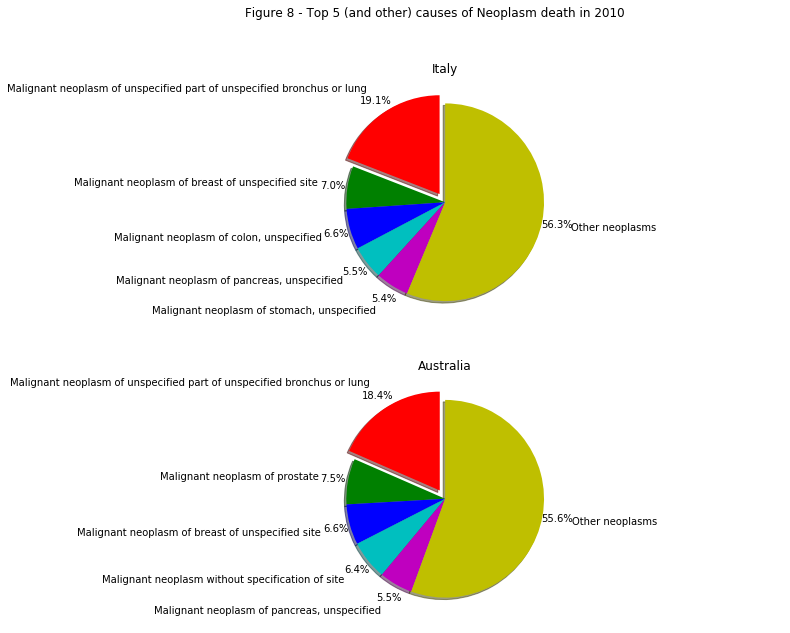

In [56]:
#create side by side piecharts to visualise the data above
fig = plt.figure(figsize=(12,10))
axes1 = fig.add_subplot(211)
axes2 = fig.add_subplot(212)
#colours = ['#C7B299', '#A67C52', '#C69C6E', '#754C24', '#534741', '#754C24']
colours=list('rgbcmy')
explode = [0.1, 0, 0, 0, 0, 0]
axes1.axis('equal')        

#italy
axes1.pie(italy_top5_2010['percent'], colors=colours, shadow=True, startangle=90,
       explode=explode, labels=italy_top5_2010['icd_desc'], autopct='%.1f%%',
       pctdistance=1.15, labeldistance=1.3)
axes1.set_title("Italy")

#australia
axes2.pie(australia_top5_2010['percent'], colors=colours, shadow=True, startangle=90,
       explode=explode, labels=australia_top5_2010['icd_desc'], autopct='%.1f%%',
       pctdistance=1.15, labeldistance=1.3)
axes2.set_title("Australia")

fig.suptitle("Figure 8 - Top 5 (and other) causes of Neoplasm death in 2010")

plt.show()



### Discussion - Comparing frequency of Neoplasm deaths in Italy and Australia, 2010

<html>
<font color='green' font=2>
In order to compare frequency of deaths between Australia and Italy (which have widely differing population numbers) in 2010, it was decided to calculate a death rate (number of deaths for relevant category as a precentage of total population in the country in 2010).
Looking at Figure 5 above, it is clear that the death rates from cancer for all age-groups follows a similar pattern in both Italy and Australia. There is a rise of death rate with age-group until age 84, after which there is a sharp fall. However, the cancer death rate is lower for all age-groups in Australia (apart from age-group 25-29).<br>
This is also supported by Figure 6 above which shows the overall death rate from all cancers in 2010 for Italy vs. Australia (roughly 0.28% vs 0.19%). <br>
Figure 7 shows the overall death rate from cancer for Italy and Australia split by sex. This reinforces the message from Figures  5 and 6. Australia has a lower death rate from cancer for both males and females. In fact the death rate for Italian males from cancer in 2010 was twice that of Australian women (0.34% vs. 0.17%).<br>
Any hypothesis that might propose that the higher overall death rate from cancer in Italy may be due to a population that is more skewed to the elderly would be contradicted by Figure 5, which shows that the death rate is lower for ALL age-groups.<br>
Looking at Figure 8, which compares the top 5 causes of cancer deaths in the two countries, it can be seen that lung cancer accounts for the highest number of cancer deaths in both countries (18.4% for Australia, 19.1% for Italy). Breast cancer and pancreatic cancer are also in the top 5 cancer deaths for both countries. However prostrate cancer, which is the second largest cancer death cause in Australia, does not appear in the Italian top 5. <br>
Comparing the death rates for the top-5 cancer deaths between the two countries is made challenging since there is such a large category for unspecified cancer in the Australian data, suggesting different recording mechanisms than Italy. It would definitely be worth finding out why that is. As suggested this data provides means for targeting the most common cancers, provided data on cause of death is correctly recorded.<br>
Generally this latter issue points to the limitations of this data when comparing countries - different countries may use different protocols for recording deaths, and while this is not the case for Italy and Australia, may report age groups differently and may even use different revisions of the ICD codes.
</font>
</html>